In [266]:
%run /data/NNDSP/anal/analysis_notebooks/util.ipynb

# Baracus Performance

## Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [48]:
analysis_version = "2018_06_27"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derivatives/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv


## Load Baracus Data

In [11]:
bar_subj = [p.as_posix() for p in bids_bar.glob('sub-*')] # search all subj in baracus directory
df_bar_subj = pd.DataFrame(bar_subj, columns = ['subj_path']) # turn the subjects into df
df_bar_subj = df_bar_subj.assign(participant = lambda df: df.subj_path.str.extract('sub-(\d{2,4})', expand=True)) # add participant number column

In [12]:
df_single_subject = get_single_subject(df_bar_subj, to_int=False) # get cortical thickness, cortical surface area, sub cort volume and stacked anat age predictions

In [15]:
# Getting Age
df_target = pd.read_csv(brain_age_file, sep=',') # open file with ages
del df_target['nuclear_fam_id']
del df_target['Sex']
del df_target['MRN']

In [16]:
df_bar_subj = df_bar_subj.merge(df_single_subject, on='participant') # merge subje with their age predictions

In [17]:
df_bar_subj = df_bar_subj.assign(MASKID = lambda df: pd.DataFrame([int(x) for x in df.participant]))
df_bar_subj = df_bar_subj.merge(df_target, on='MASKID') # merge age predictions with actual age 

In [20]:
df_bar_subj.head()

,subj_path,participant,aseg,area,thickness,stacked-anatomy,MASKID,age_at_scan
0,/gpfs/gsfs6/users/NNDSP/derivatives/bar_subj/s...,1889,24.4132,127.106,23.7235,25.9323,1889,9.667351
1,/gpfs/gsfs6/users/NNDSP/derivatives/bar_subj/s...,2011,28.0193,115.121,21.5305,25.6429,2011,18.310746
2,/gpfs/gsfs6/users/NNDSP/derivatives/bar_subj/s...,1948,36.9531,112.181,32.0494,33.4655,1948,14.269678
3,/gpfs/gsfs6/users/NNDSP/derivatives/bar_subj/s...,1198,33.5741,112.062,43.5544,36.189,1198,14.390144
4,/gpfs/gsfs6/users/NNDSP/derivatives/bar_subj/s...,1371,19.7048,117.152,33.1597,26.8287,1371,16.621492


## Mean Absolute Error

In [18]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

# calculate absolute error for each modality
print("Mean Absolute Error (Aseg):", mean_absolute_error(df_bar_subj.iloc[:, 2], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_bar_subj.iloc[:, 3], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_bar_subj.iloc[:, 4], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7]))

Mean Absolute Error (Aseg): 10.7794454526
Mean Absolute Error (Area): 105.017535768
Mean Absolute Error (Thickness): 15.864500892
Mean Absolute Error (Stacked Model): 13.7877541396


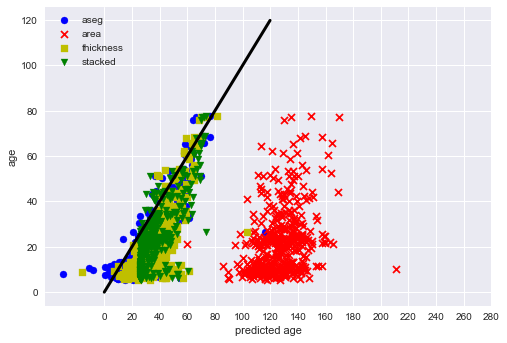

In [19]:
bar_plot(df_bar_subj)

# Train LeiCA_LIFE Models on NNDSP Data

In [49]:
# Getting Brain Age
df_target = pd.read_csv(brain_age_file, sep=',')
del df_target['nuclear_fam_id']
del df_target['MRN']

## Setup

In [50]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [51]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derivatives/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derivatives/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv


## Load Subjects

In [52]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

## Extract Freesurfer Data

In [53]:
subjects_to_analyze = subject_to_anal(subj_dirs, bids_bar)
features = extract_features(subjects_to_analyze, bids_bar)

## Train Freesurfer Data

### Single Modal: Cortical Thickness

In [54]:
df_data_ct = get_source_data('thickness', features, df_target) # extract thickness info from features
df_data_ct = df_data_ct.sort_values(by='MASKID')

In [55]:
#split test and train data into equal parts
X_train_ct, X_test_ct, y_train_ct, y_test_ct, pipe_ct = train_test_pipeline(df_data_ct.iloc[:, :5124], df_data_ct.iloc[:,5126], test_size = 0.5, random_state=None)
# fit model
pipe_ct.fit(X=X_train_ct, y=y_train_ct)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [56]:
# prediction and errors
y_predicted_train_ct = pipe_ct.predict(X_train_ct)
y_predicted_test_ct = pipe_ct.predict(X_test_ct)

In [57]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ct, y_predicted_train_ct))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ct, y_predicted_test_ct))

Mean Absolute Error (Train): 0.0993523703328
Mean Absolute Error (Test): 5.78668239833


In [58]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction 
y_predicted_ct_cv = cross_val_predict(pipe_ct, X_train_ct, y_train_ct)

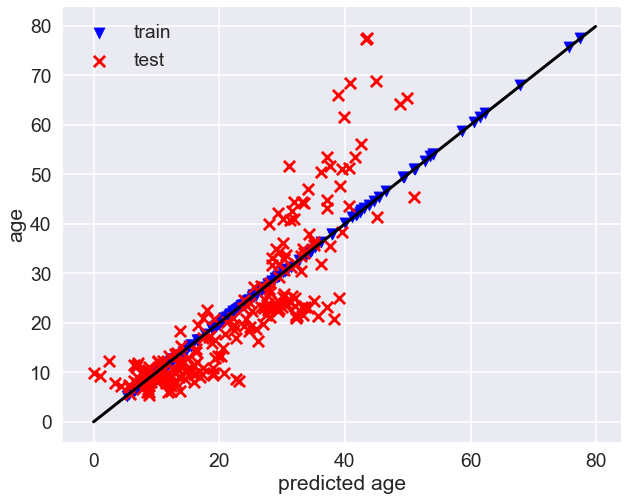

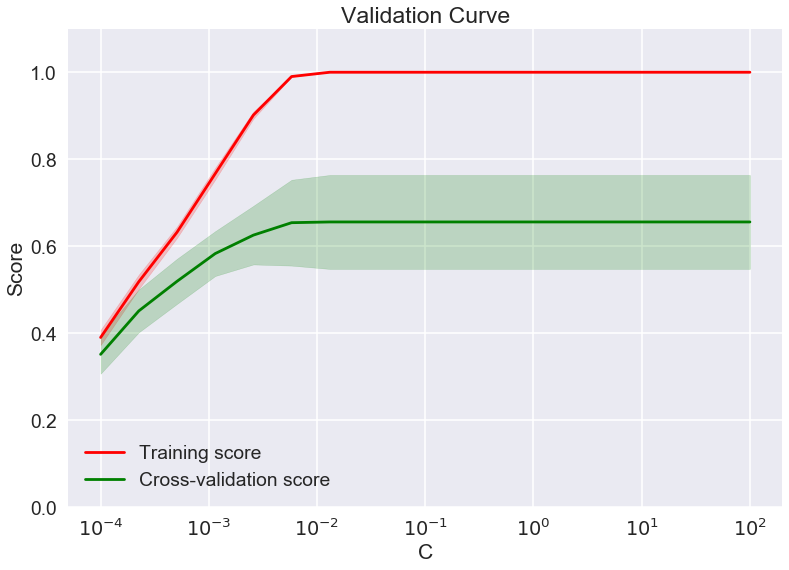

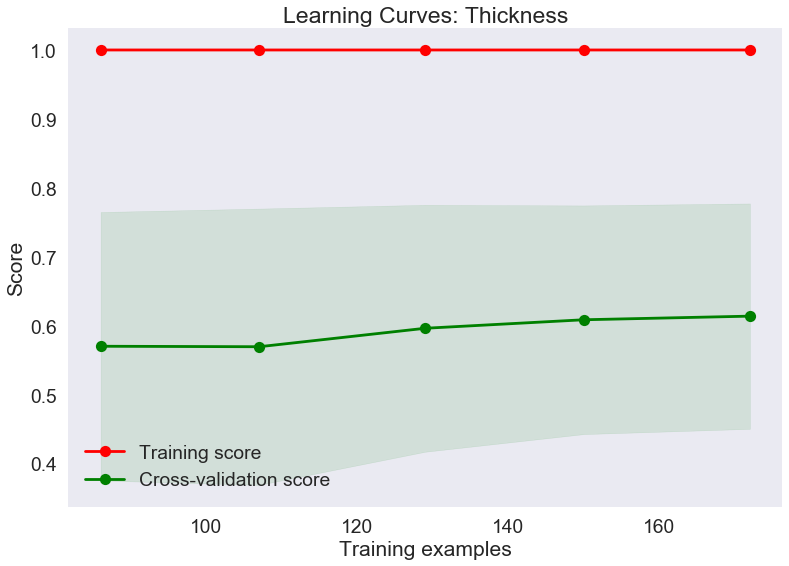

In [268]:
plot_pred(y_predicted_train_ct, y_train_ct, y_predicted_test_ct, y_test_ct, fig_tuple=(10,8), context='poster') # plot predicted versus age
plot_validation_curve(pipe_ct, X_train_ct, y_train_ct) # plot C versus training and validation score
learning_curve_fct(X_train_ct, y_train_ct, 'Thickness', pipe_ct) # plot number of features training examples versus validation close

### Single Modal: Subcortical Volumes

In [62]:
df_data_sv = get_source_data('aseg', features, df_target)
df_data_sv = df_data_sv.sort_values(by='MASKID')

In [63]:
# Train Test Split
X_train_sv, X_test_sv, y_train_sv, y_test_sv, pipe_sv = train_test_pipeline(df_data_sv.iloc[:, :66], df_data_sv.iloc[:,68], test_size = 0.5, random_state=666, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_sv.fit(X=X_train_sv, y= y_train_sv.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [64]:
# prediction and errors
y_predicted_train_sv = pipe_sv.predict(X_train_sv)
y_predicted_test_sv = pipe_sv.predict(X_test_sv)

In [65]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_sv, y_predicted_train_sv))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_sv, y_predicted_test_sv))

Mean Absolute Error (Train): 3.83867129304
Mean Absolute Error (Test): 5.46357243972


In [66]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_sv_cv = cross_val_predict(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel())

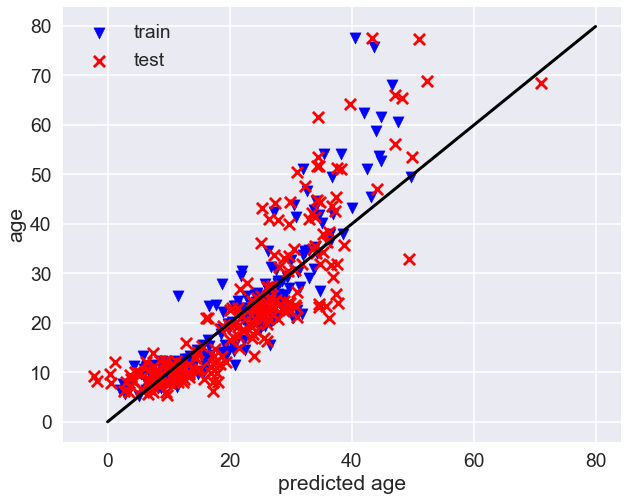

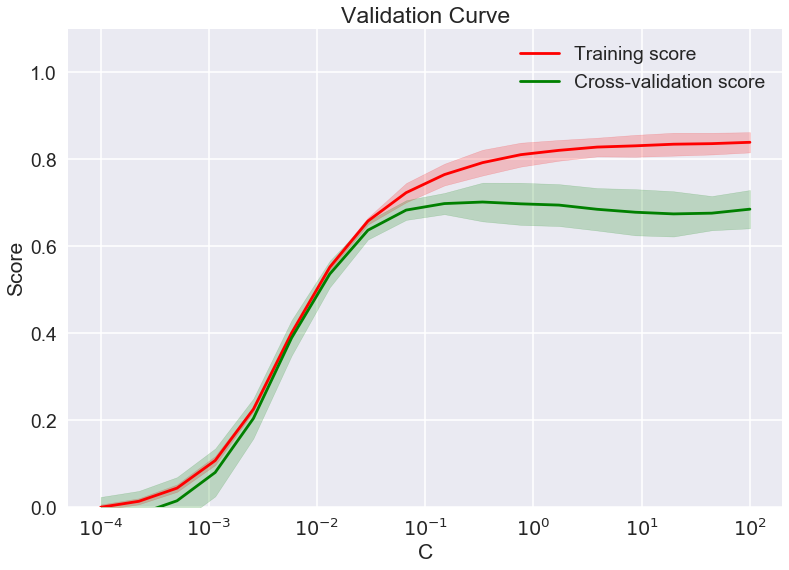

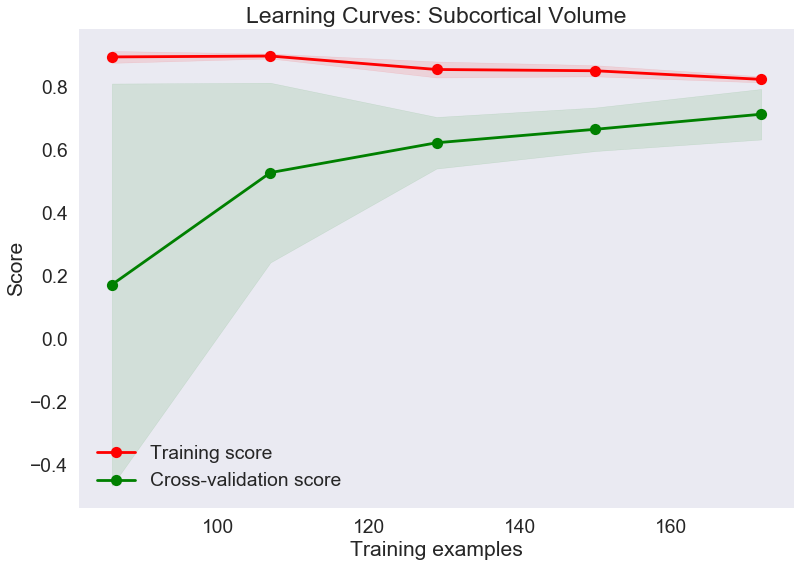

In [270]:
plot_pred(y_predicted_train_sv, y_train_sv, y_predicted_test_sv, y_test_sv, context='poster') # plot predicted age vs age
plot_validation_curve(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel()) # plot C versis training and validation scroe
learning_curve_fct(X_train_sv, y_train_sv.as_matrix().ravel(), 'Subcortical Volume', pipe_sv) # plot number of training examples vs training and validation score

In [68]:
%store X_train_sv 
%store X_test_sv
%store y_train_sv 
%store y_test_sv

Stored 'X_train_sv' (DataFrame)
Stored 'X_test_sv' (DataFrame)
Stored 'y_train_sv' (DataFrame)
Stored 'y_test_sv' (DataFrame)


### Single Modal: Cortical Surface Area

In [69]:
df_data_ca = get_source_data('area', features, df_target)
df_data_ca = df_data_ca.sort_values(by='MASKID')

In [70]:
# Train Test Split

#split test and train data into equal parts
X_train_ca, X_test_ca, y_train_ca, y_test_ca, pipe_ca = train_test_pipeline(df_data_ca.iloc[:, :5124], df_data_ca.iloc[:,5126], test_size = 0.5, random_state=666, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_ca.fit(X=X_train_ca, y=y_train_ca.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [71]:
# prediction and errors
y_predicted_train_ca = pipe_ca.predict(X_train_ca)
y_predicted_test_ca = pipe_ca.predict(X_test_ca)

In [72]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_train_ca))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ca, y_predicted_test_ca))

Mean Absolute Error (Train): 0.0999979629232
Mean Absolute Error (Test): 7.10600906568


In [73]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_ca_cv = cross_val_predict(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_ca_cv))

Mean Absolute Error (Train): 7.74552135596


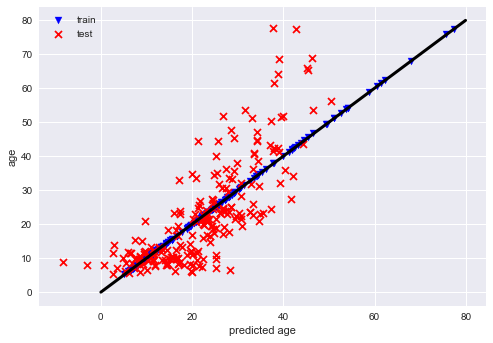

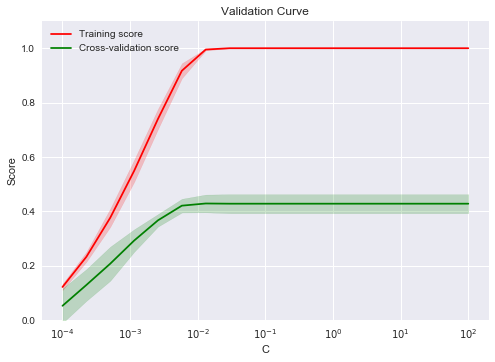

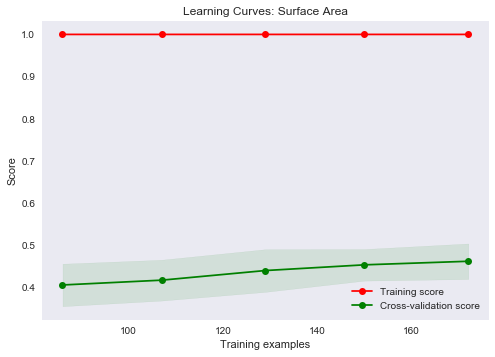

In [74]:
plot_pred(y_predicted_train_ca, y_train_ca, y_predicted_test_ca, y_test_ca)
plot_validation_curve(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
learning_curve_fct(X_train_ca, y_train_ca.as_matrix().ravel(), 'Surface Area', pipe_ca)

In [75]:
%store df_data_ct
%store df_data_sv
%store df_data_ca

Stored 'df_data_ct' (DataFrame)
Stored 'df_data_sv' (DataFrame)
Stored 'df_data_ca' (DataFrame)


### Stacked Anatomy

In [76]:
# stack predicted values
# get stacked age predictions (test and train) for ct
df_y_ct = get_stacked_ages(y_train_ct, y_predicted_train_ct, y_predicted_ct_cv, y_test_ct, y_predicted_test_ct, first=True)
# get stacked age prediction (test and train) for ca
df_y_ca = get_stacked_ages(y_train_ca, y_predicted_train_ca, y_predicted_ca_cv, y_test_ca, y_predicted_test_ca)
# get stacked age prediction (test and train) for sv
df_y_sv = get_stacked_ages(y_train_sv, y_predicted_train_sv, y_predicted_sv_cv, y_test_sv, y_predicted_test_sv)

In [77]:
# stacking function inputes
target = 'age'

source_dict = {'aseg': df_y_sv, 'ct': df_y_ct,'ca': df_y_ca}

source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}

#### Training Random Forest Function

In [78]:
scores_test, dd_train, dd_test, pipe_stack = stacking(source_dict, source_selection_dict, target, show=False)

Fitting stacking model
best max_depth: 17


In [79]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan, dd_train.pred_age_train))
print("Mean Absolute Error (Test):", mean_absolute_error(dd_test.age_at_scan, dd_test.pred_age_test))
scores_test

Mean Absolute Error (Train): 1.54978600198
Mean Absolute Error (Test): 4.24879524408


,r2,rpear,rpear2,mae,medae
aseg,0.743262,0.866112,0.750149,5.463572,3.811724
ct,0.717018,0.855053,0.731115,5.786682,4.396534
ca,0.605000,0.782641,0.612527,7.106009,5.644551
mean_pred,0.762524,0.896359,0.803459,5.213247,4.253912
pred_age_test,0.844726,0.919714,0.845874,4.248795,2.756769


In [80]:
y_predicted_stack_cv = cross_val_predict(pipe_stack, dd_train.iloc[:,:3], dd_train.age_at_scan.values)
print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan.values, y_predicted_stack_cv))

Mean Absolute Error (Train): 4.87081358532


# Train Basic Anatomical Features

## Setup

In [81]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [95]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derivatives/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv


## Load Subjects

In [96]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

In [97]:
subjects_to_analyze = subject_to_anal(subj_dirs, bids_bar)

## Extract Anatomical Feature Data

In [98]:
df_atf = pd.DataFrame([])
df_atf = df_atf.assign(MASKID = [int(x[4:]) for x in subjects_to_analyze])
df_atf = df_atf.merge(df_target, on = 'MASKID')

In [99]:
white_matter, grey_matter, csf, intra_cran_vol = get_anat_features(subjects_to_analyze, bids_bar)

In [100]:
# calculate white matter fraction
white_matter = calc_fraction(white_matter, intra_cran_vol)
# calculate grey matter fraction
grey_matter = calc_fraction(grey_matter, intra_cran_vol)
# calculate csf fraction
csf = calc_fraction(csf, intra_cran_vol)

In [101]:
df_atf = df_atf.assign(Intra_Cran_Vol = intra_cran_vol)
df_atf = df_atf.assign(WM_Frac = white_matter)
df_atf = df_atf.assign(GM_Frac = grey_matter)
df_atf = df_atf.assign(CSF_Frac = csf)
df_atf = df_atf.sort_values(by='MASKID')

## Train Basic Anatomical Feature Data

In [103]:
X_train_ct

,0,1,2,3,4,5,6,7,8,9,...,5114,5115,5116,5117,5118,5119,5120,5121,5122,5123
66,3.153003,2.732922,2.326430,3.672713,2.901413,2.595332,2.136822,2.508520,2.346667,2.219124,...,3.496120,3.483403,3.220741,3.654656,3.173508,4.266453,2.936966,3.218259,1.833373,2.181068
99,2.707571,2.485179,2.164273,2.922820,2.489574,2.670443,2.653316,1.675013,2.414391,2.460526,...,1.938594,3.863153,3.706792,3.629081,2.384445,3.492065,3.377178,3.744781,2.848563,2.609190
345,2.958253,3.070905,2.824168,3.752107,3.568703,2.195103,2.320312,0.501468,2.704085,2.763000,...,2.036991,2.938052,3.104543,3.494580,2.395537,2.525027,1.663116,2.406519,1.798785,2.257922
156,2.377317,2.643486,2.295427,2.300112,2.765476,3.191702,3.206870,0.723758,2.769311,2.070946,...,3.160732,3.968691,3.329229,3.218449,2.639813,3.933214,2.485018,2.936461,2.127581,2.924594
41,2.186415,2.509064,2.328967,2.339452,2.082101,2.829421,1.882150,2.094583,2.725460,2.931591,...,1.810052,3.008821,3.523124,3.437008,3.820976,3.246767,2.721161,2.873008,2.048410,2.456644
319,1.647785,2.992472,2.851238,4.052152,2.717504,3.215816,1.745170,0.029113,2.876149,1.816028,...,2.315896,1.844530,2.737246,2.554883,2.382464,1.941406,2.186881,2.428578,3.335881,2.479503
101,3.208155,2.657315,2.377054,2.845994,2.740232,3.442108,2.658470,0.762788,2.339366,2.325354,...,2.090416,3.441491,2.445327,3.996586,2.594580,3.007839,3.213007,2.904237,1.816312,1.830850
369,3.318237,2.691468,2.841590,3.025148,3.255561,2.874955,3.008039,0.000000,2.876035,2.605301,...,1.467079,2.144873,3.074914,2.946847,3.355161,3.340022,3.239008,3.310959,3.120309,2.749292
149,3.369646,2.488880,2.397723,2.735487,3.172999,2.794899,1.545903,0.577039,2.552503,2.918434,...,3.259249,2.970922,4.204408,3.648512,3.569492,4.291577,1.941864,3.200094,2.910848,3.904639
248,2.334723,3.114327,2.812822,2.984877,2.787692,3.080624,3.134131,0.486952,2.197388,3.590490,...,1.216572,1.805052,3.591513,3.673085,2.682510,2.784191,1.897023,3.790360,2.358723,2.086215


In [106]:
X_train_atf, X_test_atf, y_train_atf, y_test_atf, pipe_atf =  train_test_pipeline(df_atf.iloc[:, 3:], 
                                                                                  df_atf.iloc[:, 2], 
                                                                                  test_size = 0.5, 
                                                                                  random_state=None, 
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)
pipe_atf.fit(X=X_train_atf, y=y_train_atf.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [107]:
# prediction and errors
y_predicted_train_atf = pipe_atf.predict(X_train_atf)
y_predicted_test_atf = pipe_atf.predict(X_test_atf)

In [108]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_atf, y_predicted_train_atf))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_atf, y_predicted_test_atf))

Mean Absolute Error (Train): 6.63550035306
Mean Absolute Error (Test): 6.78723908784


In [109]:
from sklearn.cross_validation import cross_val_predict

y_predicted_atf_cv = cross_val_predict(pipe_atf, X_train_atf, y_train_atf.as_matrix().ravel())

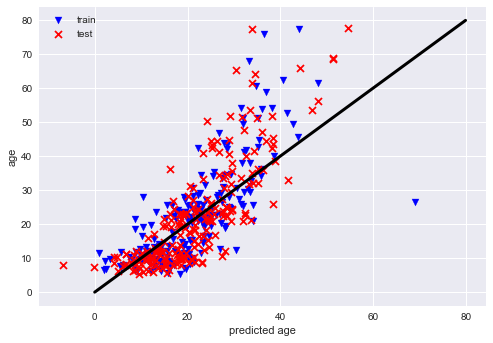

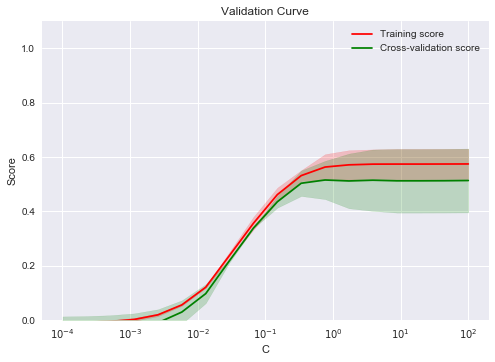

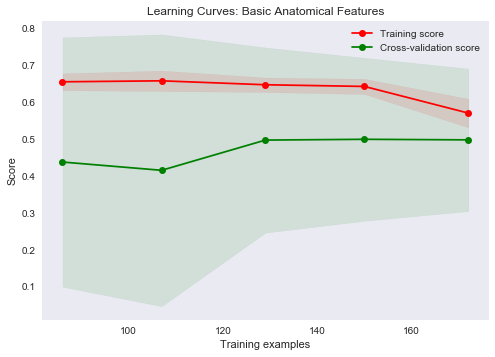

In [110]:
plot_pred(y_predicted_train_atf, y_train_ct, y_predicted_test_atf, y_test_ct)
plot_validation_curve(pipe_atf, X_train_atf, y_train_atf.as_matrix().ravel())
learning_curve_fct(X_train_atf, y_train_atf.as_matrix().ravel(), 'Basic Anatomical Features', pipe_atf)

In [111]:
%store X_train_atf
%store X_test_atf
%store y_train_atf
%store y_test_atf
%store df_atf

Stored 'X_train_atf' (DataFrame)
Stored 'X_test_atf' (DataFrame)
Stored 'y_train_atf' (DataFrame)
Stored 'y_test_atf' (DataFrame)
Stored 'df_atf' (DataFrame)


# Test HCP Data

## Setup

In [112]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [115]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derivatives/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derivatives/bar_subj') # baracus bids

# HCP Directory
hcp_dir = Path('/data/HCP/HCP_900/s3/hcp')

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP Outfir of Prepared Freesurfer Files
hcp_bar_dir = project_dir.joinpath('derivatives/bar_hcp_subj/')

# HCP Freesurfer Data
hcp_fs_dir = project_dir.joinpath('derivatives/fs_hcp_subj/')

print(hcp_fs_dir.absolute())

/gpfs/gsfs6/users/NNDSP/derivatives/fs_hcp_subj


## Load Subjects

In [116]:
# get all the necessary surf and stats file paths
get_files = False

if get_files:
    hcp_fs_subj = [p.as_posix() for p in hcp_dir.glob('??????')]
    hcp_fs_surf_subj = [p+'/T1w/'+p[len(p)-6:]+'/surf' for p in hcp_fs_subj]
    hcp_fs_stats_subj = [p+'/T1w/'+p[len(p)-6:]+'/stats' for p in hcp_fs_subj]

## Extract HCP Data

### Extract Subject Ages

In [117]:
import matplotlib.pyplot as plt
df_hcp_age = pd.read_csv(project_dir.joinpath('nino/HCP_ages.csv'))
df_hcp_age = pd.DataFrame(df_hcp_age[['Subject','Age_in_Yrs']])

### Extract HCP Data Simple Model

In [119]:
import os
from glob import glob

# get the subjects in the freesurfer directory
hcp_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(hcp_bar_dir, "sub-*")))]

In [121]:
hcp_subjects_to_analyze = subject_to_anal(hcp_subj_dirs, hcp_bar_dir)

In [122]:
# get age and subject number
df_hcp_atf = pd.DataFrame([])
df_hcp_atf = df_hcp_atf.assign(Subject = [int(x[4:]) for x in hcp_subjects_to_analyze])
df_hcp_atf = df_hcp_atf.merge(df_hcp_age, on = 'Subject')

In [123]:
white_matter_hcp, grey_matter_hcp, csf_hcp, intra_cran_vol_hcp = get_anat_features(hcp_subjects_to_analyze, hcp_bar_dir)

In [124]:
# calculate white matter fraction
white_matter_hcp = calc_fraction(white_matter_hcp, intra_cran_vol_hcp)

# calculate grey matter fraction
grey_matter_hcp = calc_fraction(grey_matter_hcp, intra_cran_vol_hcp)

# calculate csf fraction
csf_hcp = calc_fraction(csf_hcp, intra_cran_vol_hcp)

In [125]:
df_hcp_atf = df_hcp_atf.assign(Intra_Cran_Vol = intra_cran_vol_hcp)
df_hcp_atf = df_hcp_atf.assign(WM_Frac = white_matter_hcp)
df_hcp_atf = df_hcp_atf.assign(GM_Frac = grey_matter_hcp)
df_hcp_atf = df_hcp_atf.assign(CSF_Frac = csf_hcp)

### Extract HCP Data Complex Model

In [126]:
hcp_features = extract_features(hcp_subjects_to_analyze, hcp_bar_dir)

## Test HCP Data

In [127]:
bar_subj_hcp = [p.as_posix() for p in hcp_bar_dir.glob('sub-*')] # search all subj in baracus directory
df_bar_subj_hcp = pd.DataFrame(bar_subj_hcp) # turn the subjects into df
df_bar_subj_hcp.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj_hcp = df_bar_subj_hcp.assign(Subject = lambda df: df.subj_path.str.extract('sub-(\d{2,6})', expand=True))# add participant number column

In [128]:
df_single_subject_hcp = get_single_subject(df_bar_subj_hcp)

In [129]:
# merge aseg, ca, thickness and stacked model with real ages
df_single_subject_hcp = df_single_subject_hcp.rename(columns={'participant': 'Subject'})
df_single_subject_hcp = df_single_subject_hcp.sort_values(by='Subject')
df_single_subject_hcp = df_single_subject_hcp.merge(df_hcp_age, on = 'Subject')

In [130]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_single_subject_hcp.iloc[:, 1], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_single_subject_hcp.iloc[:, 2], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_single_subject_hcp.iloc[:, 3], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_single_subject_hcp.iloc[:, 4], df_single_subject_hcp.iloc[:, 5]))

Mean Absolute Error (Aseg): 8.60684507508
Mean Absolute Error (Area): 108.869897623
Mean Absolute Error (Thickness): 13.3445398192
Mean Absolute Error (Stacked Model): 7.92587784783


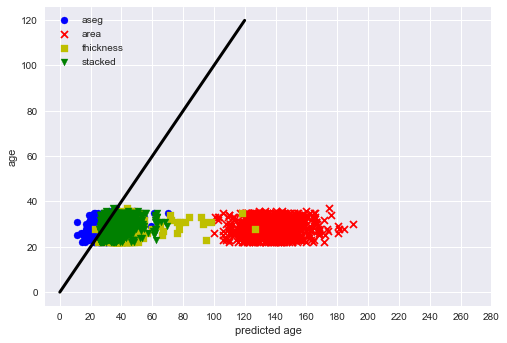

In [131]:
bar_plot(df_single_subject_hcp, start_at = 1, end_at=5)

### Test Against Complex Model

In [132]:
df_data_hcp_ct = get_source_data('thickness', hcp_features, df_hcp_age, on='Subject')

In [133]:
y_predicted_hcp_ct = pipe_ct.predict(df_data_hcp_ct.iloc[:,:5124])

In [134]:
df_data_hcp_sv = get_source_data('aseg', hcp_features, df_hcp_age, on='Subject')

In [135]:
y_predicted_hcp_sv = pipe_sv.predict(df_data_hcp_sv.iloc[:,:66])

In [136]:
%store df_data_hcp_sv

Stored 'df_data_hcp_sv' (DataFrame)


In [137]:
df_data_hcp_ca = get_source_data('area', hcp_features, df_hcp_age, on='Subject')

In [138]:
y_predicted_hcp_ca = pipe_ca.predict(df_data_hcp_ca.iloc[:,:5124])

In [139]:
#### Stacked Anatomy
df_stack_hcp = pd.DataFrame([])
df_stack_hcp['aseg'] = y_predicted_hcp_sv
df_stack_hcp['ct'] = y_predicted_hcp_ct
df_stack_hcp['ca'] = y_predicted_hcp_ca
df_stack_hcp['Subject'] = df_data_hcp_ct.Subject.values

In [140]:
y_predicted_stack_hcp = pipe_stack.predict(df_stack_hcp.iloc[:,:3])

In [141]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp))

Mean Absolute Error (HCP): 5.62256930021


### Test Against Simple Model

In [142]:
# test HCP Inputs with Simple Model
y_predicted_hcp_atf = pipe_atf.predict(df_hcp_atf.iloc[:, 2:])

In [143]:
# y_predicted_hcp_atf vs. age assigned

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf))

Mean Absolute Error (HCP): 9.48744040233


In [144]:
%store df_hcp_atf

Stored 'df_hcp_atf' (DataFrame)


# Test NKI Data

## Setup

In [146]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derivatives/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derivatives/bar_subj') # baracus bids

# NKI Directory
nki_dir = Path('/data/NNDSP/anal/NKI')

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# NKI Behavioral Data File
nki_bh_file = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv')

# NKI baracus
nki_bar_dir = project_dir.joinpath('derivatives/bar_nki_subj/')

# NKI Freesurfer Data
nki_fs_dir = project_dir.joinpath('derivatives/fs_nki_subj/')

print(nki_fs_dir.absolute())

/gpfs/gsfs6/users/NNDSP/derivatives/fs_nki_subj


In [147]:
df_nki_ages = pd.read_csv(project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv'), sep='\t')

## Extract NKI Data

In [148]:
import os
from glob import glob

# get the subjects in the freesurfer directory
nki_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(nki_bar_dir, "sub-*")))]

In [149]:
nki_subjects_to_analyze = subject_to_anal(nki_subj_dirs, nki_bar_dir)

In [150]:
# get age and subject number
df_nki_atf = pd.DataFrame([])
df_nki_atf = df_nki_atf.assign(participant_name = [x for x in nki_subjects_to_analyze])
df_nki_atf = df_nki_atf.assign(participant_id = [x[4:13] for x in df_nki_atf.participant_name.values])
df_nki_atf = df_nki_atf.drop_duplicates(subset='participant_id', keep='first')
df_nki_atf = df_nki_atf.merge(df_nki_ages, on = 'participant_id')

In [151]:
white_matter_nki, grey_matter_nki, csf_nki, intra_cran_vol_nki = get_anat_features(df_nki_atf.participant_name.values, nki_bar_dir)

In [152]:
# calculate white matter fraction
white_matter_nki = calc_fraction(white_matter_nki, intra_cran_vol_nki)

# calculate grey matter fraction
grey_matter_nki = calc_fraction(grey_matter_nki, intra_cran_vol_nki)

# calculate csf fraction
csf_nki = calc_fraction(csf_nki, intra_cran_vol_nki)

In [153]:
df_nki_atf = df_nki_atf.assign(Intra_Cran_Vol = intra_cran_vol_nki)
df_nki_atf = df_nki_atf.assign(WM_Frac = white_matter_nki)
df_nki_atf = df_nki_atf.assign(GM_Frac = grey_matter_nki)
df_nki_atf = df_nki_atf.assign(CSF_Frac = csf_nki)

### Extract NKI Data Complex Model

In [154]:
nki_features = extract_features(df_nki_atf.participant_name.values, nki_bar_dir)

### Test against LeiCa_LIFE Model

In [155]:
df_bar_subj_nki = pd.DataFrame([p.as_posix() for p in nki_bar_dir.glob('sub-*')]) # search all subj in baracus directory and turn the subjects into df
df_bar_subj_nki.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj_nki = df_bar_subj_nki.assign(participant_id = lambda df: df.subj_path.str.extract('sub-(A\d{2,8})', expand=True))# add participant number column

In [156]:
df_bar_subj_nki = df_bar_subj_nki.sort_values(by='participant_id')
df_bar_subj_nki = df_bar_subj_nki.drop_duplicates(subset='participant_id', keep='first')

In [157]:
df_bar_subj_nki = df_bar_subj_nki.merge(df_nki_ages, on='participant_id')

In [158]:
df_single_subject_nki = get_single_subject(df_bar_subj_nki, to_int=False)

In [159]:
# merge aseg, ca, thickness and stacked model with real ages
df_single_subject_nki = df_single_subject_nki.rename(columns={'participant': 'participant_id'})
df_single_subject_nki = df_single_subject_nki.sort_values(by='participant_id')
df_single_subject_nki = df_single_subject_nki.merge(df_nki_ages, on = 'participant_id')

In [160]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_single_subject_nki.iloc[:, 1], df_single_subject_nki.age))
print("Mean Absolute Error (Area):", mean_absolute_error(df_single_subject_nki.iloc[:, 2], df_single_subject_nki.age))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_single_subject_nki.iloc[:, 3], df_single_subject_nki.age))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_single_subject_nki.iloc[:, 4], df_single_subject_nki.age))

Mean Absolute Error (Aseg): 10.0268668575
Mean Absolute Error (Area): 100.530877128
Mean Absolute Error (Thickness): 9.83434243637
Mean Absolute Error (Stacked Model): 9.45275023262


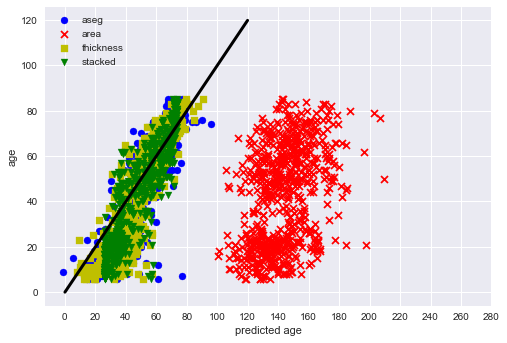

In [161]:
bar_plot(df_single_subject_nki, start_at=1, end_at=5)

### Test Against Complex Model

In [162]:
df_data_nki_ct = get_source_data('thickness', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [163]:
y_predicted_nki_ct = pipe_ct.predict(df_data_nki_ct.iloc[:,:5124])

In [164]:
df_data_nki_sv = get_source_data('aseg', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [165]:
y_predicted_nki_sv = pipe_sv.predict(df_data_nki_sv.iloc[:,:66])

In [166]:
df_data_nki_ca = get_source_data('area', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [167]:
y_predicted_nki_ca = pipe_ca.predict(df_data_nki_ca.iloc[:,:5124])

In [168]:
#### Stacked Anatomy
df_stack_nki = pd.DataFrame([])
df_stack_nki['aseg'] = y_predicted_nki_sv
df_stack_nki['ct'] = y_predicted_nki_ct
df_stack_nki['ca'] = y_predicted_nki_ca
df_stack_nki['participant_id'] = df_data_nki_ct.participant_id.values

In [169]:
y_predicted_stack_nki = pipe_stack.predict(df_stack_nki.iloc[:,:3])

In [170]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_data_nki_ca.age, y_predicted_stack_nki))

Mean Absolute Error (NKI): 10.1611434233


In [171]:
%store df_data_nki_sv

Stored 'df_data_nki_sv' (DataFrame)


In [172]:
%store df_nki_atf
%store nki_features
%store df_nki_ages

Stored 'df_nki_atf' (DataFrame)
Stored 'nki_features' (list)
Stored 'df_nki_ages' (DataFrame)


### Test Against Simple Model

In [173]:
if 'participant_name' in df_nki_atf.columns:
    del df_nki_atf['participant_name']

In [174]:
# test HCP Inputs with Simple Model
y_predicted_nki_atf = pipe_atf.predict(df_nki_atf.iloc[:, 4:])

In [175]:
# y_predicted_hcp_atf vs. age assigned

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf))

Mean Absolute Error (NKI): 12.0152360657


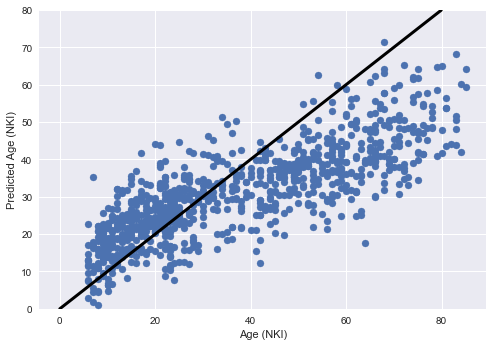

In [176]:
import matplotlib.pyplot as plt

plt.scatter(df_nki_atf.age, y_predicted_nki_atf)
plt.plot(numpy.arange(0,80,0.1), numpy.arange(0,80,0.1), c='black', linewidth = 3)
plt.xlabel("Age (NKI)")
plt.ylabel("Predicted Age (NKI)")
plt.ylim(0, 80)
plt.show()

In [177]:
%store df_nki_atf

Stored 'df_nki_atf' (DataFrame)


# Statistical Tests

In [233]:
%run /data/NNDSP/anal/analysis_notebooks/stat_tests.ipynb

## Hypothesis #1

If we train a previously presented machine learning model predicting age from a large number of derived anatomical features on a new data set, it will perform better than chance at predicting age outside of the training data.

### Chance on Shaw Data

In [179]:
# get all the subject ages from Shaw Data
subject_ages = [x for x in df_data_ca.age_at_scan]
df_subject_ages = pd.DataFrame(subject_ages)
# df of random age predictions
df_random_ages = pd.DataFrame([])
df_random_ages = df_random_ages.assign(MASKID = df_data_ca.MASKID)

In [180]:
df_random_ages = random_its(1000, df_random_ages, subject_ages)

In [181]:
arr_mae = get_arr_mae(df_random_ages, df_subject_ages)

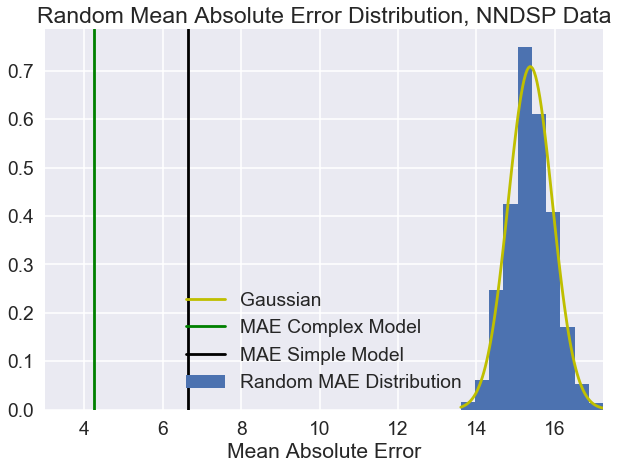

In [234]:
lines = {
    'MAE Complex Model' : scores_test.get_value(index='pred_age_test', col='mae'),
    'MAE Simple Model' : mean_absolute_error(y_train_atf, y_predicted_train_atf),
    #'MAE Simple Stacked Model' : mean_absolute_error(y_test_atf, y_predicted_test_ss),
}
plot_rand_hist(arr_mae, lines, title='Random Mean Absolute Error Distribution, NNDSP Data', set_context='poster',
               fig_tuple=(10, 7))

In [191]:
print("Percentile of MAE Complex Model", percentile(arr_mae, scores_test.get_value(index='pred_age_test', col='mae')))

Percentile of MAE Complex Model 0.0


In [192]:
print("Percentile of MAE Simple Model", percentile(arr_mae, mean_absolute_error(y_train_atf, y_predicted_train_atf)))

Percentile of MAE Simple Model 0.0


In [193]:
print("Percentile of MAE Baracus", percentile(arr_mae, mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7])))

Percentile of MAE Baracus 0.2


### Chance on HCP Data

In [194]:
# get all the subject ages
subject_hcp_ages = [x for x in df_hcp_age.Age_in_Yrs]
df_hcp_subject_ages = pd.DataFrame(subject_hcp_ages)
# df of random age predictions
df_hcp_random_ages = pd.DataFrame([])
df_hcp_random_ages = df_hcp_random_ages.assign(Subject = df_hcp_age.Subject)

In [195]:
df_hcp_random_ages = random_its(1000, df_hcp_random_ages, subject_hcp_ages)

In [196]:
arr_mae_hcp = get_arr_mae(df_hcp_random_ages, df_hcp_subject_ages)

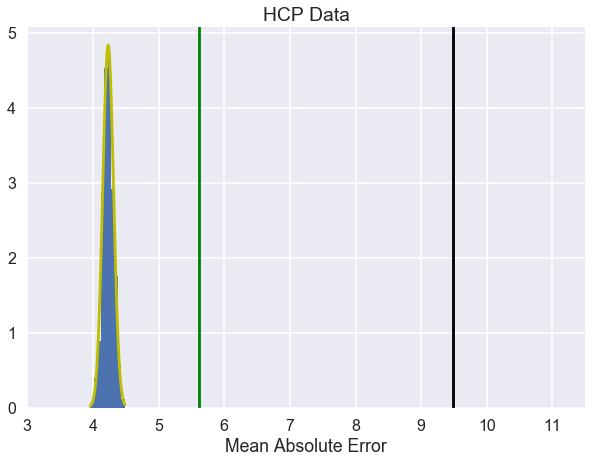

In [230]:
hcp_lines = {
    'MAE Complex Model (HCP)' : mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp),
    'MAE Simple Model (HCP)' : mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf)
}
plot_rand_hist(arr_mae_hcp, hcp_lines, x_max = 11.5, title='HCP Data',
              set_context='poster', fig_tuple=(10, 7), legend=False)

In [199]:
print("Percentile of MAE Complex Model (HCP)", percentile(arr_mae_hcp, 
                                                    mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp)))

Percentile of MAE Complex Model (HCP) 100.0


In [200]:
print("Percentile of MAE Simple Model (HCP)", percentile(arr_mae_hcp, 
                                                  mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf)))

Percentile of MAE Simple Model (HCP) 100.0


In [201]:
print("Percentile of MAE Baracus (HCP)", percentile(arr_mae_hcp,
                                                    mean_absolute_error(df_single_subject_hcp.iloc[:, 4], df_single_subject_hcp.iloc[:, 5])))

Percentile of MAE Baracus (HCP) 100.0


### Chance on NKI Data

In [202]:
# get all the subject ages
subject_nki_ages = [x for x in df_nki_atf.age]
df_nki_subject_ages = pd.DataFrame(subject_nki_ages)
# df of random age predictions
df_nki_random_ages = pd.DataFrame([])
df_nki_random_ages = df_nki_random_ages.assign(participant_id = df_nki_atf.participant_id)

In [203]:
df_nki_random_ages = random_its(1000, df_nki_random_ages, subject_nki_ages)

In [204]:
arr_mae_nki = get_arr_mae(df_nki_random_ages, df_nki_subject_ages)

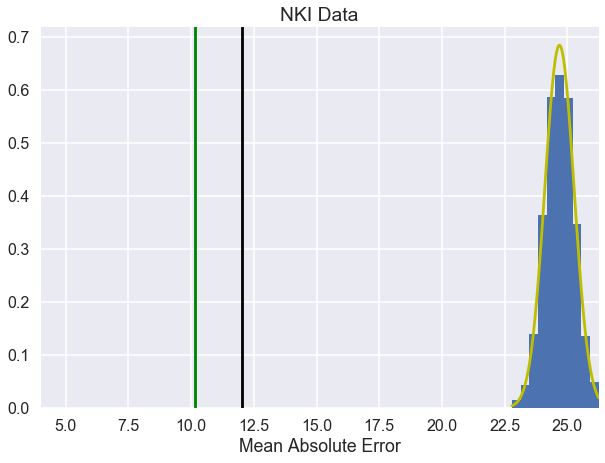

In [224]:
nki_lines = {
    'MAE Complex Model (NKI)' : mean_absolute_error(df_data_nki_ca.iloc[:,5125], y_predicted_stack_nki),
    'MAE Simple Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf),
    #'MAE Simple Stacked Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_ss),
}
plot_rand_hist(arr_mae_nki, nki_lines, xlim_min =4, title='NKI Data',
              set_context='poster', fig_tuple=(10, 7), legend=False)

In [213]:
print("Percentile of MAE Complex Model (NKI)", percentile(arr_mae_nki, 
                                                    mean_absolute_error(df_data_nki_ca.iloc[:,5125], 
                                                                        y_predicted_stack_nki)))

Percentile of MAE Complex Model (NKI) 0.0


In [214]:
print("Percentile of MAE Simple Model (NKI)", percentile(arr_mae_nki, 
                                                  mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf)))

Percentile of MAE Simple Model (NKI) 0.0


In [215]:
print("Percentile of MAE Baracus (HCP)", percentile(arr_mae_nki,
                                                    mean_absolute_error(df_single_subject_nki.age, df_single_subject_nki.iloc[:, 5])))

Percentile of MAE Baracus (HCP) 0.0


## Hypothesis #2 

The model trained with many derived features will have better out of sample performance than a model trained with fewer, simpler features.

### Complex Model vs. Simple Model

In [216]:
temp_tr = y_train_atf.assign(y_pred = y_predicted_train_atf).sort_index()

statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_tr.y_pred.values, temp_tr.age_at_scan.values), 
                                      np.subtract(dd_train.pred_age_train, dd_train.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  10507.0 
 Pvalue:  0.227122738377 
 Correlation:  0.452497846684


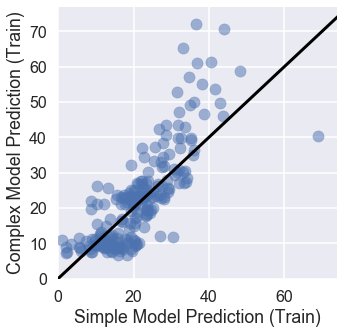

In [217]:
plot_simple_v_complex(temp_tr.y_pred.values, dd_train.pred_age_train, "(Train)")

In [218]:
temp_ts = y_test_atf.assign(y_pred = y_predicted_test_atf).sort_index()
statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
                                      np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  9906.0 
 Pvalue:  0.0487880126628 
 Correlation:  0.422683051715


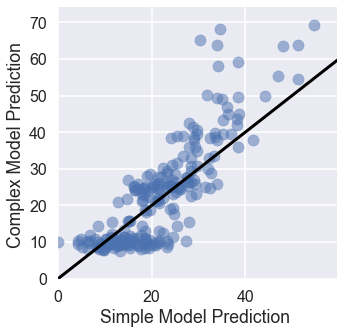

In [219]:
plot_simple_v_complex(temp_ts.y_pred, dd_test.pred_age_test, "", fig_tuple=(5, 5), fig_title='simple_graph.png')

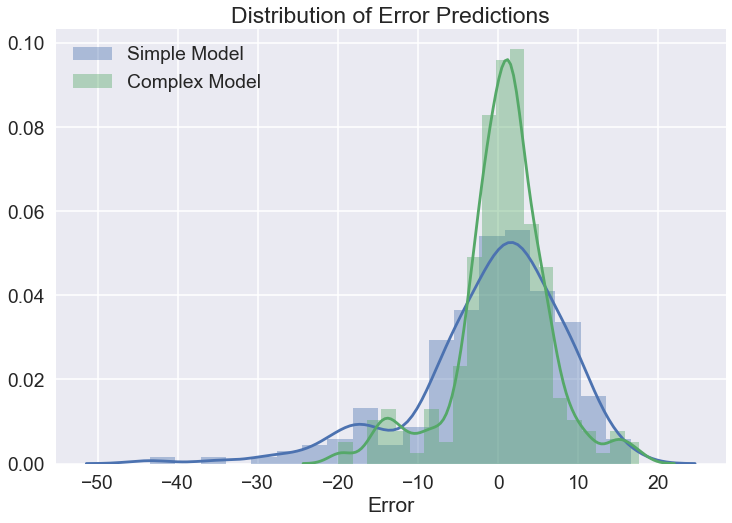

In [235]:
plot_list = {
    "Simple Model" : np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
    "Complex Model" : np.subtract(dd_test.pred_age_test, dd_test.age_at_scan),
}
plot_ae_hist(plot_list, title='Distribution of Error Predictions', set_context='poster',
            fig_tuple=(12, 8), file_title='simple_hist.png')

In [236]:
%store dd_test

Stored 'dd_test' (DataFrame)


## Hypothesis #3

The model trained with many derived features will perform better than the model with fewer, simpler features when tested on data collected at different sites. 

### HCP Data

#### Complex Model vs Simple Model

In [237]:
%store -r y_predicted_hcp_ss

In [238]:
df_hcp_pred_data = get_wil_helper(df_hcp_atf, y_predicted_hcp_atf, y_predicted_hcp_ss, 
                                  y_predicted_stack_hcp, df_hcp_age, subj='Subject')

In [239]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.Atf_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  52846.0 
 Pvalue:  3.40310598343e-81 
 Correlation:  0.13179868316


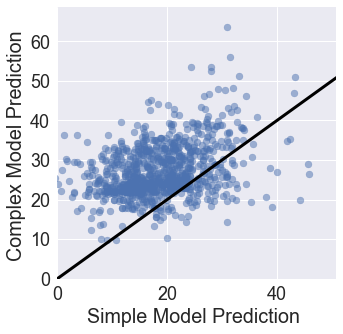

In [149]:
plot_simple_v_complex(df_hcp_pred_data.atf_pred, df_hcp_pred_data['stack'], title='', 
                      label='Simple', fig_tuple=(5, 5))

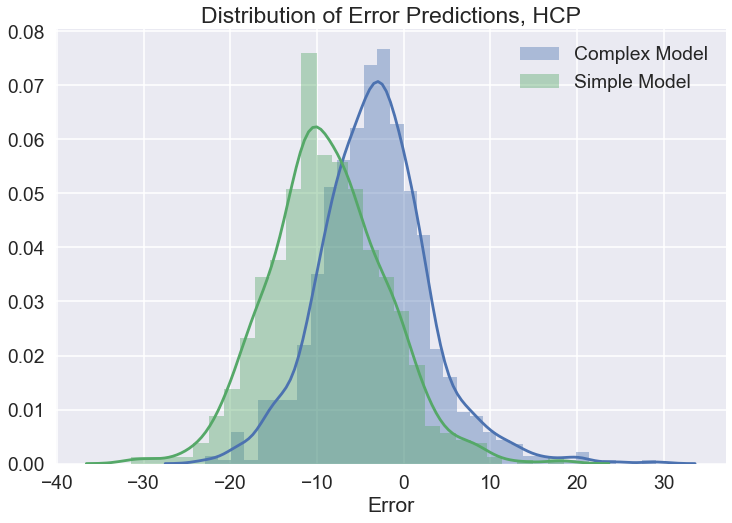

In [254]:
plot_list_hcp = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Model" : df_hcp_pred_data.Atf_Err
}
plot_ae_hist(plot_list_hcp, title='Distribution of Error Predictions, HCP', set_context='poster',
            fig_tuple=(12, 8))

In [151]:
%store df_hcp_pred_data

Stored 'df_hcp_pred_data' (DataFrame)


#### Complex Model vs Simple Stacked Model

In [240]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.SS_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  63792.0 
 Pvalue:  7.21138900037e-70 
 Correlation:  0.159098164405


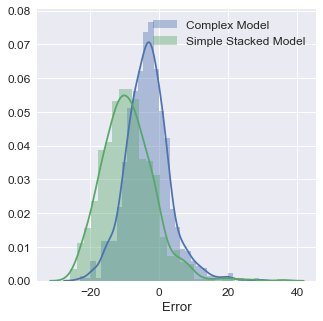

In [251]:
plot_list_hcp_s = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Stacked Model" : df_hcp_pred_data.SS_Err
}
plot_ae_hist(plot_list_hcp_s)

### NKI Data

#### Complex Model vs Simple Model

In [242]:
%store -r y_predicted_nki_ss

In [243]:
df_nki_pred_data = get_wil_helper(df_nki_atf, y_predicted_nki_atf, y_predicted_nki_ss, y_predicted_stack_nki,
                                 df_nki_ages, subj='participant_id')

In [244]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.Atf_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  175493.0 
 Pvalue:  0.00423746654133 
 Correlation:  0.44460574185


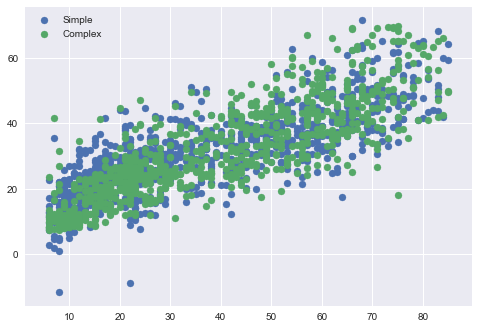

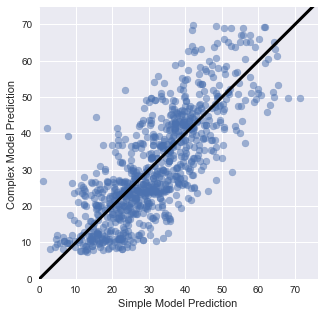

In [245]:
import seaborn as sns
sns.set_context('notebook')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data.atf_pred, label = 'Simple')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data['stack'], label ='Complex')
plt.legend(loc='best')
plt.show()
plot_simple_v_complex(df_nki_pred_data.atf_pred, df_nki_pred_data['stack'], title='',
                     fig_tuple=(5, 5), fig_title='nki_graph.png')

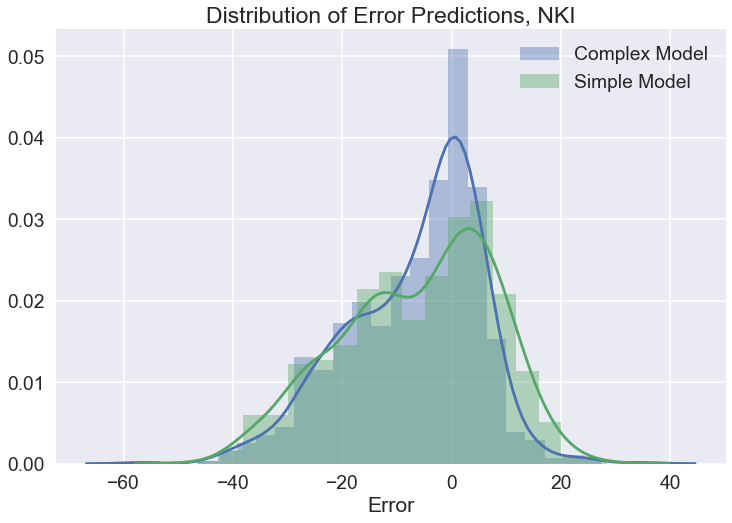

In [263]:
plot_list_nki = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Model" : df_nki_pred_data.Atf_Err
}
plot_ae_hist(plot_list_nki, title='Distribution of Error Predictions, NKI', set_context='poster',
            fig_tuple=(12, 8))

In [259]:
%store df_nki_pred_data

Stored 'df_nki_pred_data' (DataFrame)


#### Complex Model vs Simple Stacked Model

In [248]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.SS_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  197034.0 
 Pvalue:  0.966196658402 
 Correlation:  0.499179156659


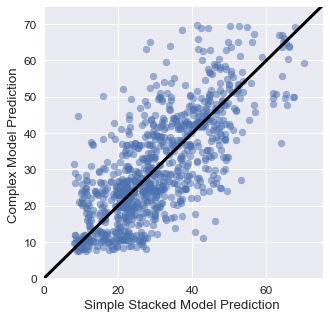

In [249]:
plot_simple_v_complex(df_nki_pred_data.ss_pred, df_nki_pred_data['stack'], title='', 
                      label='Simple Stacked', fig_tuple=(5, 5))

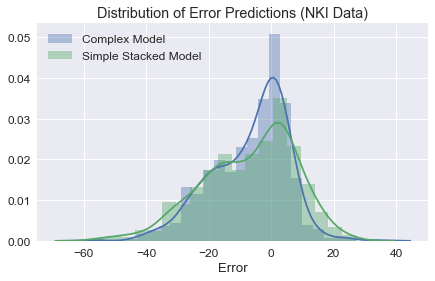

In [250]:
plot_list_nki_s = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Stacked Model" : df_nki_pred_data.SS_Err
}
plot_ae_hist(plot_list_nki_s, title='Distribution of Error Predictions (NKI Data)', set_context='notebook',
            fig_tuple=(7, 4))

# Exploratory Analysis

## Train Test Split

In [164]:
df_tt_split = mult_iterations(400, df_data_ct, df_data_sv, df_data_ca, df_data_hcp_ct, df_data_hcp_sv, df_data_hcp_ca, df_data_nki_ct, df_data_nki_sv, df_data_nki_ca,
                   df_atf, df_hcp_atf, df_nki_atf)

Fitting stacking model
best max_depth: 3
0
Fitting stacking model
best max_depth: 5
1
Fitting stacking model
best max_depth: 9
2
Fitting stacking model
best max_depth: 5
3
Fitting stacking model
best max_depth: 5
4
Fitting stacking model
best max_depth: 4
5
Fitting stacking model
best max_depth: 3
6
Fitting stacking model
best max_depth: 4
7
Fitting stacking model
best max_depth: 5
8
Fitting stacking model
best max_depth: 4
9
Fitting stacking model
best max_depth: 5
10
Fitting stacking model
best max_depth: 5
11
Fitting stacking model
best max_depth: 12
12
Fitting stacking model
best max_depth: 3
13
Fitting stacking model
best max_depth: 4
14
Fitting stacking model
best max_depth: 6
15
Fitting stacking model
best max_depth: 4
16
Fitting stacking model
best max_depth: 4
17
Fitting stacking model
best max_depth: 3
18
Fitting stacking model
best max_depth: 4
19
Fitting stacking model
best max_depth: 4
20
Fitting stacking model
best max_depth: 4
21
Fitting stacking model
best max_depth: 3


best max_depth: 5
184
Fitting stacking model
best max_depth: 4
185
Fitting stacking model
best max_depth: 4
186
Fitting stacking model
best max_depth: 3
187
Fitting stacking model
best max_depth: 3
188
Fitting stacking model
best max_depth: 4
189
Fitting stacking model
best max_depth: 5
190
Fitting stacking model
best max_depth: 5
191
Fitting stacking model
best max_depth: 4
192
Fitting stacking model
best max_depth: 4
193
Fitting stacking model
best max_depth: 3
194
Fitting stacking model
best max_depth: 4
195
Fitting stacking model
best max_depth: 5
196
Fitting stacking model
best max_depth: 9
197
Fitting stacking model
best max_depth: 4
198
Fitting stacking model
best max_depth: 4
199
Fitting stacking model
best max_depth: 4
200
Fitting stacking model
best max_depth: 15
201
Fitting stacking model
best max_depth: 17
202
Fitting stacking model
best max_depth: 3
203
Fitting stacking model
best max_depth: 8
204
Fitting stacking model
best max_depth: 3
205
Fitting stacking model
best max

best max_depth: 4
366
Fitting stacking model
best max_depth: 4
367
Fitting stacking model
best max_depth: 8
368
Fitting stacking model
best max_depth: 6
369
Fitting stacking model
best max_depth: 4
370
Fitting stacking model
best max_depth: 6
371
Fitting stacking model
best max_depth: 4
372
Fitting stacking model
best max_depth: 4
373
Fitting stacking model
best max_depth: 5
374
Fitting stacking model
best max_depth: 3
375
Fitting stacking model
best max_depth: 3
376
Fitting stacking model
best max_depth: 5
377
Fitting stacking model
best max_depth: 4
378
Fitting stacking model
best max_depth: 4
379
Fitting stacking model
best max_depth: 4
380
Fitting stacking model
best max_depth: 4
381
Fitting stacking model
best max_depth: 6
382
Fitting stacking model
best max_depth: 4
383
Fitting stacking model
best max_depth: 4
384
Fitting stacking model
best max_depth: 6
385
Fitting stacking model
best max_depth: 4
386
Fitting stacking model
best max_depth: 5
387
Fitting stacking model
best max_d

In [168]:
df_tt_split.head()

,stack_ts,stack_hcp,stack_nki,simple_ts,simple_hcp,simple_nki,pval_ts,pval_hcp,pval_nki
0,4.31326,5.21719,8.88666,6.58418,10.7322,12.6449,0.0166906,7.91839e-109,1.59253e-19
1,3.88606,5.53871,8.33963,6.87314,10.1738,12.6105,0.0398539,9.5753e-119,6.94748e-23
2,4.32291,5.60234,9.54572,7.45288,10.8739,13.5433,0.00195472,8.42092e-123,7.62108e-19
3,4.2179,5.24233,8.72992,6.64627,9.51845,12.9229,0.1964,1.39309e-118,1.62177e-10
4,3.97966,5.54372,7.90955,6.77133,9.45943,12.8832,0.745072,6.21325e-112,4.47204e-28


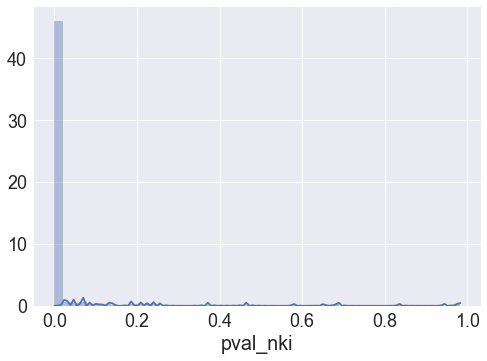

In [170]:
sns.distplot(df_tt_split.pval_nki)
plt.show()

In [171]:
df_tt_split[df_tt_split.pval_nki > 0.05]

,stack_ts,stack_hcp,stack_nki,simple_ts,simple_hcp,simple_nki,pval_ts,pval_hcp,pval_nki
16,3.93101,5.1435,9.70749,7.15596,10.2333,13.2556,0.273018,3.31495e-105,0.133987
35,4.06496,6.1462,9.72286,6.99122,10.0585,13.2341,0.328268,5.5558e-84,0.578103
42,4.39868,5.72528,10.5425,6.86339,10.0578,13.388,0.241967,9.38228e-113,0.142756
54,4.54008,4.61225,10.3346,7.35659,9.92577,13.4642,0.480345,3.05034e-113,0.0603437
63,4.42572,5.51114,9.78581,6.69331,9.12227,12.5741,0.473607,2.13086e-95,0.102601
65,4.18749,5.29542,9.13725,6.81619,9.55958,12.679,0.292506,1.31205e-108,0.207297
74,3.88369,5.00773,9.75425,6.55451,9.46498,12.2801,0.134288,9.23722e-100,0.213537
77,3.85604,4.53329,9.76353,6.64283,9.94281,12.1334,0.287548,9.50228e-110,0.188844
85,3.8173,4.57736,10.5896,6.69891,10.1376,13.1492,0.247703,1.13905e-122,0.94213
96,4.09594,4.98155,10.6526,7.45408,10.1197,13.4457,0.453054,6.62465e-120,0.067464


In [ ]:
plt.scatter(df_tt_split.stack_ts, df_tt_split.stack_nki)
plt.scatter(df_tt_split.simple_ts, df_tt_split.simple_nki)
plt.show()